<a href="https://colab.research.google.com/github/Mikaner/reinforcement/blob/main/Studing_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 言語理解のためのTransformerモデル
ここを参照しました。
https://www.tensorflow.org/tutorials/text/transformer?hl=ja


In [1]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 492.5 MB 4.2 kB/s 
     |████████████████████████████████| 13.4 MB 245 kB/s 
     |████████████████████████████████| 462 kB 44.2 MB/s 
     |████████████████████████████████| 1.4 MB 38.6 MB/s 
     |████████████████████████████████| 5.8 MB 41.0 MB/s 
     |████████████████████████████████| 2.1 MB 40.5 MB/s 


### データセットのダウンロード

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteY47LH5/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteY47LH5/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteY47LH5/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [3]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [4]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [5]:
for ts in tokenized_string:
    print( '{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [7]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]

    return lang1, lang2

In [8]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

Note: サンプルを小さく、より速くするため、長さが40トークンを超えるサンプルを削除する。

In [9]:
MAX_LENGTH = 40

In [10]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

In [11]:
train_preprocessed = (
    train_examples
    .map(tf_encode)
    .filter(filter_max_length)
    # 読み取り時のスピードアップのため、データセットをメモリ上にキャッシュする
    .cache()
    .shuffle(BUFFER_SIZE)
)

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length)
)

In [12]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 )

val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
               )

In [13]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

### 位置エンコーディング
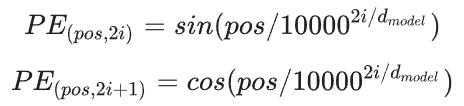

In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [15]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    # 配列中の偶数インデックスにはsinを適用; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 配列中の奇数インデックスにはcosを適用; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


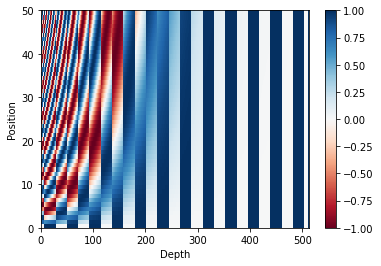

In [16]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

↑　なにこれ ← テストじゃね？

### マスキング
パディングされたトークンをマスクする。
これによってパディング(補正された空白のトークン)を入力として扱わないようにする。

マスクはパディング値0の存在を示す。
→0の場所で1を出力する

In [17]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # アテンション・路地っとにパディングを追加するため
    # さらに時限を追加する。
    return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [18]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

シーケンス中の未来のトークンをマスクするため、 ルックアヘッド・マスクが使われている。<br>
→このマスクはどのエントリーを使うべきではないかを示している。


以下のコードは3番目の単語を予測するために、1つ目と2つ目の単語だけが使われるということを意味している。
同じように、4つ目の単語を予測するには、1,2,3つ目の単語だけが使用され、次も同様となる。


In [19]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

In [20]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### スケール済み内積アテンション
<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png?hl=ja" width="500" alt="scaled_dot_product_attention">

アテンション関数の入力 Q(query), K(key), V(value)の重み計算は以下。

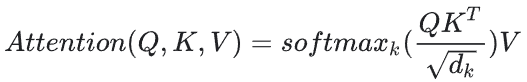

内積アテンションは深度の平方根をファクターとしてスケールされている。
これは、深度が大きくなると、内積が非常に大きくなり、ソフトマックスにて小さな値しか返さなくなってしまうため。

In [21]:
def scaled_dot_product_attention(q, k, v, mask):
    """アテンションの重みの計算
    q, k, vは最初の次元が一致していること
    k, vは最後から2番目の次元が一致していること
    マスクは型(パディングかルックアヘッドか)によって異なるshapeを持つが、
    加算の際にブロードキャスト可能であること
    引数:
       q: query shape == (..., seq_len_q, depth)
       k: key shape == (..., seq_len_k, depth)
       v: value shape == (..., seq_len_v, depth_v)
       mask: (..., seq_len_q, seq_len_k)にブロードキャスト可能な
             shapeを持つ浮動小数点テンソル。規定値はNone
    
    戻り値:
       出力、アテンションの重み
    """
    # 行列積の計算
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., seq_len_q, seq_len_k)

    # matmul_qkをスケール
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # マスクをスケール済みテンソルに加算
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax は最後の軸(seq_len_k)について
    # 合計が1となるように正規化
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v) # (..., seq_len_q, depth_v)

    return output, attention_weights

ソフトマックス正規化がKに対して行われるため、その値がQに割り当てる重要度を決めることになる。

出力はアテンションの重みとV(value)ベクトルの積を表している。
これにより、注目したい単語がそのまま残され、それ以外の単語は破棄される。

以下はテスト用のコード

In [22]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None
    )
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [23]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32) # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32) # (4, 2)

# この`query`は2番目の`key`に割り付けられているので
# 2番目の`value`が返される
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [24]:
# このクエリは(3番目と 4番目の)繰り返しキーに割り付けられるので
# 関連したすべての値が平均される
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [25]:
# このクエリは最初と2番目のキーに等しく割り付けられるので
# それらの値が平均される
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32) # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [26]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32) # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## マルチヘッド・アテンション



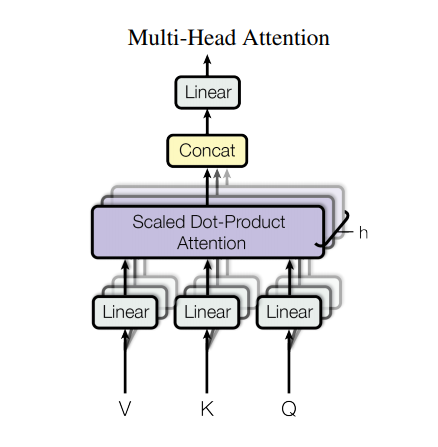

マルチヘッドアテンションは4つのパートから成り立つ。
- 線形レイヤーとマルチヘッドへの分割
- スケール済み内積アテンション
- マルチヘッドの結合
- 最終線形レイヤー

各マルチヘッドアテンションブロックは3つの入力を取り、その入力は線形レイヤーを通されマルチヘッドに分割される。

`scaled_dot_product_attention`は各ヘッドに適用される。
アテンションステップにおいて適切なマスクを使用する必要がある。その後、各ヘッドのアテンション出力は結合され、最後のDenseレイヤに通される。

Q,K,Vは複数のヘッドに分割される。それによってモデルが異なる表現空間の異なる位置の情報について、連携してアテンションを計算できるからである。
分割後の各ヘッドの次元を小さくすることで全体の計算コストをすべての次元を持つ単一のアテンションヘッドを用いた場合と同一に出来る。

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # なにこれ←なんか次元を小さくして計算コストを単一アテンションヘッドと同じにするらしい

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """最後の次元を(num_heads, depth)に分割。
        結果をshapeが(batch_size, num_heads, seq_len, depth)となるようにリシェイプする。
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q) # (batch_size, seq_len, d_model)
        k = self.wk(k) # (batch_size, seq_len, d_model)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size) #(batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) #(batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) #(batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention) # (batch_size, seq_len_q, d_model)

        return output, attention_weights

試しに、MultiHeadAttentionレイヤーを作成してみる

In [28]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8) # d_modelは次元空間の数、num_headsはマルチヘッドアテンションブロックの数
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

理解したこととしては、maskは以降の入力を受け付けないやつとして実装しており、マルチヘッドアテンションは次元ごとの計算を並列化するために割って計算しているということですね。

In [29]:
tf.random.uniform((1, 60, 512))

<tf.Tensor: shape=(1, 60, 512), dtype=float32, numpy=
array([[[0.89145386, 0.81333244, 0.66143405, ..., 0.15749383,
         0.54480875, 0.7294127 ],
        [0.9748727 , 0.00158668, 0.5551493 , ..., 0.93676853,
         0.17662525, 0.01743126],
        [0.7846925 , 0.16055298, 0.2777202 , ..., 0.7916522 ,
         0.13092029, 0.82550514],
        ...,
        [0.7203617 , 0.9201963 , 0.57871115, ..., 0.22885704,
         0.5530802 , 0.76985395],
        [0.7527387 , 0.98042953, 0.6142144 , ..., 0.15305424,
         0.41976392, 0.36675215],
        [0.7541748 , 0.73156404, 0.9842938 , ..., 0.94160485,
         0.7824197 , 0.08479333]]], dtype=float32)>

## ポイントワイズのフィードフォワード・ネットワーク

ポイントワイズのフィードフォワードネットワークは2つの全結合層とそれをつなぐReLU活性化層からなる。

ポイントワイズって何？

In [30]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                                tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, diff)
                                tf.keras.layers.Dense(d_model) # (batch_size, seq_len, d_model)
    ])

In [31]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

これやってること2層のネットワーク作ってるだけだよね？
ReLU→全結合層って感じに

## エンコーダーとデコーダー

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png?hl=ja" width="600" alt="transformer">

Transformerモデルは標準のアテンション付きシーケンストゥーシーケンスモデルと同じ一般的なパターンを踏襲する。

- 入力の文は、N層のエンコーダーレイヤーを通り、シーケンス中の単語/トークンごとに出力を生成する。
- デコーダーは、エンコーダーの出力と自分自身の入力（セルフアテンション）に注目し、次の単語を予測する。

### エンコーダーレイヤー
それぞれのエンコーダーレイヤーは次のようなサブレイヤーからなっている
1. マルチヘッドアテンション (パディング・マスク付き）
2. ポイントワイズフィードフォワードネットワーク

サブレイヤーにはそれぞれ残差接続[?]があり、その後にレイヤー正規化が続く。残差接続は深いネットワークでの勾配消失問題を回避するのに役立つ。

それぞれのサブレイヤーの出力は`LayerNorm(x + Sublayer(x))`である。[このxが残差接続？]
正規化は（最後の）`d_model`軸に対して行われる。
TransformerにはN層のエンコーダーがある。

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output) # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)

        return out2

In [33]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None
)

sample_encoder_layer_output.shape # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### デコーダーレイヤー
各デコーダーレイヤーは次のようなサブレイヤーからなる

1. マスク付きマルチヘッドアテンション（ルックアヘッド・マスクおよびパディングマスク付き）
2. （パディングマスク付き）マルチヘッドアテンション。<br>V(value)とK(key)はエンコーダの出力を入力として受け取る。Q(query)はマスク付きマルチヘッドアテンションサブレイヤーの出力を受け取る
3. ポイントワイズ・フィードフォワード・ネットワーク

各サブレイヤーは残差接続を持ち、その後にレイヤー正規化が続く。
各サブレイヤーの出力は`LayerNorm(x + Sublayer(x))`である。
正規化は、（最後の）`d_model`軸に沿って行われる。

TransformerにはN層のデコーダー・レイヤーが存在する。

Qがデコーダーの最初のアテンションブロックの出力を受け取り、Kがエンコーダーの出力を受け取るとき、アテンションの重みはデコーダーの入力の、エンコーダーの出力に対する重要度を表す。
言い換えると、デコーダーはエンコーダーの出力と自分自身の出力のセルフアテンションを見て、次の単語を予測する。

上記のスケール済み内積アテンションのセクションのデモを参照。


In [34]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask) # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask
        ) # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2


In [35]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None
)

sample_decoder_layer_output.shape # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### エンコーダー
`Encoder`は次のものからできている
1. 入力の埋め込み
2. 位置エンコーディング
3. N層のエンコーダーレイヤー

入力は埋め込み層を通り、位置エンコーディングと合算される。
この加算の出力がエンコーダーレイヤーの入力である。
エンコーダーの出力はデコーダーの入力になる。

In [36]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # 埋め込みと位置エンコーディングを合算
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x # (batch_size, input_seq_len, d_model)


In [37]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape) # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### デコーダー
`Decoder`は次のものからできている
1. 出力埋め込み
2. 位置エンコーディング
3. N層のデコーダーレイヤー

ターゲットは埋め込みを通り、位置エンコーディングと加算される。
この加算の出力がデコーダーの入力になる。
デコーダーの出力は、最後の線形レイヤーの入力となる。

In [38]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x) # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)
            
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1 # 重要度(self-attentionの値)を記録
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [39]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformerの作成

Transformerは、エンコーダー、デコーダーと、最後の線形レイヤーからなる。

デコーダーの出力は、線形レイヤーの入力であり、その出力が返される。

In [40]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)
        
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

In [41]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## ハイパーパラメーターの設定
Transformerのベースモデルで使われている値は*num_layers=6, d_model = 512, dff = 2048*である。

今回は比較的高速にするため、それぞれの値を小さく設定する。

In [42]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## オプティマイザー

論文中の式に従い、カスタムの学習率スケジューラーを持った、Adamオプティマイザーを使用する。

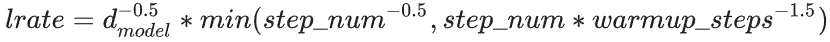

In [43]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [44]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

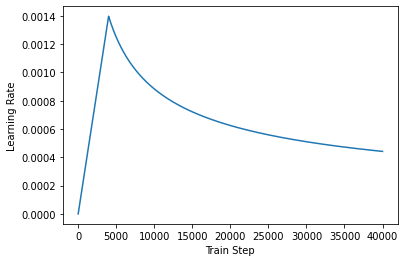

In [45]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## 損失とメトリクス

ターゲットシーケンスはパディングされているため、損失を計算する際にパディングマスクを適用することが重要である。

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [47]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [48]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy'
)

## 訓練とチェックポイント生成

In [49]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [50]:
def create_masks(inp, tar):
    # Encoderパディングマスク
    enc_padding_mask = create_padding_mask(inp)

    # デコーダーの2つ目のアテンションブロックで使用
    # このパディングマスクはエンコーダーの出力をマスクするのに使用
    dec_padding_mask = create_padding_mask(inp)

    # デコーダーの1つ円のアテンションブロックで使用
    # デコーダーが受け取った入力のパディングと将来のトークンをマスクするのに使用
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

チェックポイントのパスとチェックポイント・マネージャーを作成する。
これは、nエポックごとにチェックポイントを保存するのに使用される。

In [51]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# チェックポイントが存在したら、最後のチェックポイントを復元
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

ターゲットは、tar_inpとtar_realに分けられる。

tar_inpはデコーダーの入力として渡される。
tar_realは同じ入力を1つシフトしたものである。
tar_inputの位置のそれぞれで、tar_realは予測されるべき次のトークンを含んでいる。

例えば、`sentence` = "SOS A lion in the jungle is sleeping EOS"だとすると、次のようになる
`tar_inp` = "SOS A lion in the jungle is sleeping"
`tar_real` = "A lion in the jungle is sleeping EOS"

Transformerは自己回帰モデルなので、1回に1か所の予測を行い、その出力を次に何をすべきかの判断に使用する。

訓練時にこのサンプルはテキスト生成チュートリアルのようにティーチャーフォーシングを使用する。
ティーチャーフォーシングとは、その時点においてモデルが何を予測したかに関わらず、秦の出力を次のステップに渡すというもの。

Transformerが単語を予測するたびに、セルフアテンションのおかげで次の単語を予測するために入力シーケンスの過去の単語を参照することができる。

モデルが期待される出力を盗み見ることがないように、ルックアヘッドマスクを使用する。

In [52]:
EPOCHS = 20

In [53]:
# @tf.functionは高速に実行するためにtrain_stepをTFグラフにトレースコンパイルする。
# この関数は引数となるテンソルのshapeに特化したもの。
# シーケンスの長さや（最後のばちが小さくなるなど）バッチサイズが可変となることによって
# 再トレーシングが起きないようにするため、input_signatureを使って、より一般的なshapeを
# 指定する。

# ...？

train_step_signature = [
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64)
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape: # ようわからんけど多分この辺でティーチャーフォーシングをやってると思う
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

ポルトガル語を入力言語とし、英語をターゲット言語とする。

In [54]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
            
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                            ckpt_save_path))
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))
    
    print('Time taken for 1 epoch: {} secs\n'.format(time.time()-start))

Epoch 1 Batch 0 Loss 4.0602 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.2143 Accuracy 0.0016
Epoch 1 Batch 100 Loss 4.1705 Accuracy 0.0124
Epoch 1 Batch 150 Loss 4.1275 Accuracy 0.0164
Epoch 1 Batch 200 Loss 4.0766 Accuracy 0.0182
Epoch 1 Batch 250 Loss 4.0087 Accuracy 0.0194
Epoch 1 Batch 300 Loss 3.9246 Accuracy 0.0230
Epoch 1 Batch 350 Loss 3.8347 Accuracy 0.0267
Epoch 1 Batch 400 Loss 3.7542 Accuracy 0.0297
Epoch 1 Batch 450 Loss 3.6726 Accuracy 0.0326
Epoch 1 Batch 500 Loss 3.6072 Accuracy 0.0357
Epoch 1 Batch 550 Loss 3.5469 Accuracy 0.0388
Epoch 1 Batch 600 Loss 3.4927 Accuracy 0.0423
Epoch 1 Batch 650 Loss 3.4371 Accuracy 0.0458
Epoch 1 Batch 700 Loss 3.3817 Accuracy 0.0492
Epoch 1 Loss 3.3794 Accuracy 0.0493
Time taken for 1 epoch: 183.2257616519928 secs

Epoch 2 Batch 0 Loss 2.7840 Accuracy 0.1035
Epoch 2 Batch 50 Loss 2.5986 Accuracy 0.0981
Epoch 2 Batch 100 Loss 2.5784 Accuracy 0.1025
Epoch 2 Batch 150 Loss 2.5465 Accuracy 0.1055
Epoch 2 Batch 200 Loss 2.5278 Accuracy 0.1082
Ep

## 評価
評価は次のステップで行われる。
- ポルトガル語のトークナイザー(tokenizer_pt)を使用して入力文をエンコードする。
さらに、モデルの訓練に使用されたものと同様に、開始及び終了トークンを追加する。
これが入力のエンコード。
- デコーダーの入力は、start token == tokenizer_en.vocab_sizeである。
- パディングマスクとルックアヘッドマスクを計算する。
- decoderはencoder outputと自分自身の出力（セルフアテンション）を見て、予測値を出力する。
- 最後の単語を選択し、そのargmaxを計算する。
- デコーダーの入力に予測された単語を結合し、デコーダーに渡す。
- このアプローチでは、デコーダーは自分自身が予測した過去の単語に基づいて次の単語を予測する。

In [61]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp文はポルトガル語、開始及び終了トークンを追加
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # ターゲットは英語であるため、Transformerに与える最初の単語は英語の開始トークンとなる
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output, 
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # seq_len次元から最後の単語を選択
        predictions = predictions[:, -1:, :] # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # predicted_idが終了トークンと等しいなら結果を返す。
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
        
        # 出力にpredicted_idを結合し、デコーダーへの入力とする。
        output = tf.concat([output, predicted_id], axis=-1)
    
    return tf.squeeze(output, axis=0), attention_weights

In [66]:
def plot_attention_weights(attention, sentence, result, layer):
    fig =plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # アテンションの重みをプロット
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'],
            fontdict=fontdict, rotation=90)
        
        ax.set_yticklabels([tokenizer_en.decode([i])for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict)
        
        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [57]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result
                                              if i < tokenizer_en.vocab_size])
    
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [62]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve the world .
Real translation: this is a problem we have to solve .


In [63]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [64]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to be very quickly with some magic stories that happened to you .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did have .


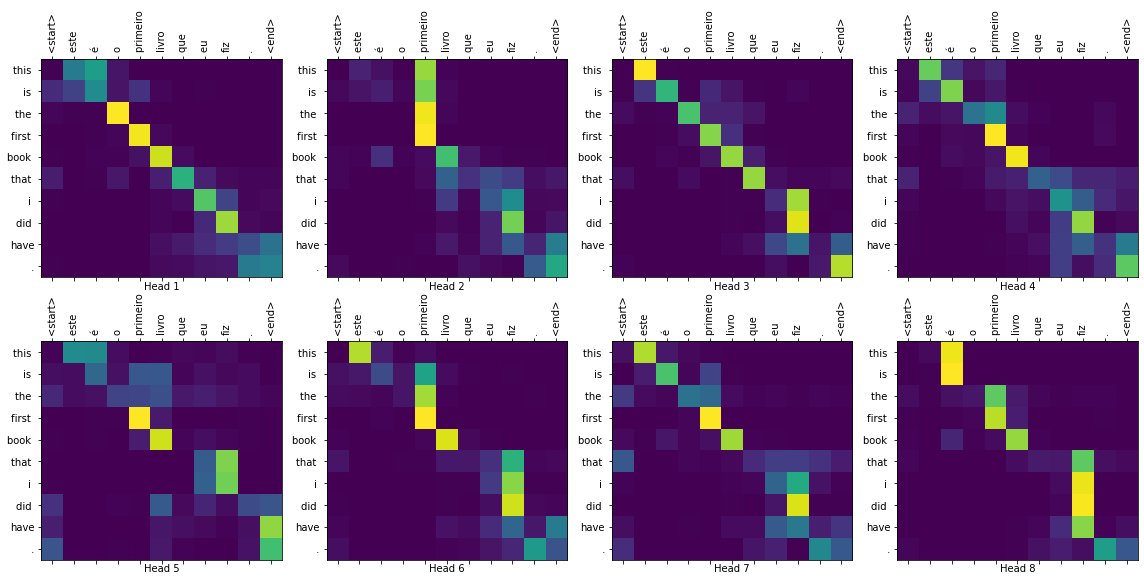

Real translation: this is the first book i've ever done.


In [67]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")